# Convolutional Neural Network

## 0. Setup 
Import packages. Set random seeds

In [1]:
import xarray as xr 
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np 
import keras_tuner as kt 
import tensorflow as tf 
from tensorflow.keras import models, layers
from tensorflow.keras import metrics 
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import regularizers
from sklearn.utils.class_weight import compute_class_weight
%config InlineBackend.figure_format = 'svg'

# Import helper functions 
import sys
sys.path.insert(0, '../../utils')
from cnn_utils import onehot

Using TensorFlow backend


2023-10-14 00:29:54.035158: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Set random seeds 
np.random.seed(220)
tf.random.set_seed(117)

## 1. Read and preprocess input data
Read in the data, convert it to numpy arrays, perform one hot encoding, and compute class weights.

In [3]:
# Class 0: no extreme precip 
# Class 1: extreme precip
classes = [0,1]

# Columns to use for labels vs. features 
labels = "precip_classes"
features_list = ["slp_anom","hgt_detrended_anom"]

In [4]:
# Directory for input data 
data_dir = "../../data/input_data_preprocessed/"

# Read csv as pandas DataFrame object
x_train_ds = xr.open_dataset(data_dir+"training/training_features.nc")
y_train_df = pd.read_csv(data_dir+"training/training_labels.csv", index_col=False)

x_val_ds = xr.open_dataset(data_dir+"validation/validation_features.nc")
y_val_df = pd.read_csv(data_dir+"validation/validation_labels.csv", index_col=False)

x_test_ds = xr.open_dataset(data_dir+"testing/testing_features.nc")
y_test_df = pd.read_csv(data_dir+"testing/testing_labels.csv", index_col=False)

### 1.1 Convert to data numpy arrays 

In [5]:
x_train = x_train_ds.to_array().transpose("time","lat","lon","variable").values
y_train = y_train_df[labels].values

x_val = x_val_ds.to_array().transpose("time","lat","lon","variable").values
y_val = y_val_df[labels].values

x_test = x_test_ds.to_array().transpose("time","lat","lon","variable").values
y_test = y_test_df[labels].values

### 1.2 Compute class weights
Class weights should be inversely proportional to frequency of each class 

In [6]:
class_weights = compute_class_weight(
    class_weight="balanced", 
    classes=np.array(classes), 
    y=y_train
)
class_weights = {classes[0]:class_weights[0], classes[1]:class_weights[1]}
print(class_weights)

{0: 0.5271939953810624, 1: 9.6932059447983}


### 1.2 Do one hot encoding on labels 

In [7]:
## Print docstrings for one hot encoding function
# print(onehot.__doc__)

In [8]:
y_train_onehot = onehot(y_train)
y_val_onehot = onehot(y_val)
y_test_onehot = onehot(y_test)

## 2. Build and train the CNN 

### 2.1 Define model hyperparameters/settings

In [9]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True
)

settings = {
    "batch_size": 2048, 
    "epochs": 500,
    "callbacks": [callback],
    "cell_output": 0, # 0: Silent during model.fit; 1: Progress bar; 2: Prints each epoch
    "class_weights": class_weights
}

### 2.2 Build the model 

In [10]:
def get_uncompiled_model(data_shape=(15, 35, 2), conv_filters=16, dense_neurons=16, dense_layers=1, activity_reg=0.001, dropout_rate=0.2): 
    """Build uncompiled CNN 
    
    Parameters
    ----------
    data_shape: tuple 
        Shape of data in the form (lat, lon, num_classes) 
    conv_filters: int 
        Number of filters to use in convolution layer 
    dense_neurons: int 
        Number of dense neurons to use in dense layer
    dense_layers: int 
        Number of dense layers to use 
    activity_reg: float 
        Regularization factor for l2 regularization 
    dropout_rate: float 
        Dropout rate

    Returns 
    -------
    keras.engine.sequential.Sequential
        Uncompiled model 
    
    """

    model = models.Sequential() 
    model.add(layers.Input(shape=data_shape)) ## define input shape

    # Convolutional and pooling layers are the feature extraction portion of the network
    model.add(layers.Conv2D(conv_filters, 
                            (3,3), activity_regularizer=regularizers.l2(0.01))) 
    model.add(layers.Activation('relu')) ## add convolutional layer
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(dropout_rate))
                            
    model.add(layers.Conv2D(conv_filters, (3,3), activity_regularizer=regularizers.l2(activity_reg))) 
    model.add(layers.Activation('relu')) ## add convolutional layer
    model.add(layers.MaxPooling2D((2,2))) ## pooling layer
    model.add(layers.Dropout(dropout_rate))
                            
    model.add(layers.Flatten()) ## converts from 2D array to 1D array

    # Feature interpretation layers 
    for i in range(dense_layers):
        model.add(layers.Dense(dense_neurons, activity_regularizer=regularizers.l2(activity_reg))) ## dense layer
        model.add(layers.Activation('relu'))
     
    model.add(layers.Dense(2, activation='softmax')) ## classifier layer (binary class where 1=extreme)
    return model 

In [11]:
def get_compiled_model(data_shape=(15, 35, 2), lr=0.0004, **kwargs): 
    """Get incompiled model, and then.... compile it 
    
    Parameters 
    ----------
    lr: float 
        Learning rate 

    Returns 
    --------
    keras.engine.sequential.Sequential
        Compiled model 
    """
    # Get uncompiled model 
    model = get_uncompiled_model(data_shape=data_shape, **kwargs) 

    # Set metrics 
    # https://stackoverflow.com/questions/58630393/does-tf-keras-metrics-auc-work-on-multi-class-problems
    # https://www.tensorflow.org/api_docs/python/tf/keras/metrics/AUC
    METRICS = [
        metrics.CategoricalAccuracy(name='accuracy'),
        metrics.Precision(class_id=1, name='precision'),
        metrics.Recall(class_id=1, name='recall'),
        tf.keras.metrics.AUC(curve="ROC", multi_label=False)
    ]

    # Compile model 
    model.compile(loss=losses.CategoricalCrossentropy(), 
                  optimizer=optimizers.Adam(learning_rate=lr), 
                  metrics=METRICS)
    return model 

In [12]:
data_shape = (x_train_ds.dims["lat"], x_train_ds.dims["lon"], 2) # lat, lon, num classes 
model = get_compiled_model(data_shape)

In [13]:
# Add initial weights at some point to preserve reproducability 

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 13, 33, 16)        304       
                                                                 
 activation (Activation)     (None, 13, 33, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 6, 16, 16)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 6, 16, 16)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 14, 16)         2320      
                                                                 
 activation_1 (Activation)   (None, 4, 14, 16)         0         
                                                        

### 2.3 Tune the model parameters 
Reference page: https://keras.io/guides/keras_tuner/getting_started/

Note to self: KT objective should be the same as the LOSS. Need to pick one. 

In [15]:
# def build_model_hp(hp): 
#     """Build and compile CNN 
    
#     Parameters 
#     ----------
#     None
    
#     Returns 
#     --------
#     keras.engine.sequential.Sequential
#         Compiled model 
#     """
#     # Define hyperparameters to optimize 
#     learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

#     # Build model
#     model = models.Sequential() 
#     model.add(layers.Input(shape=(15, 35, 2))) ## define input shape

#     # Convolutional layers
#     model.add(layers.Conv2D(16, (3,3), activity_regularizer=regularizers.l2(0.01))) 
#     model.add(layers.Activation('relu')) ## add convolutional layer
#     model.add(layers.MaxPooling2D((2,2)))
#     model.add(layers.Dropout(0.2))                  
#     model.add(layers.Conv2D(16, (3,3), activity_regularizer=regularizers.l2(0.001))) 
#     model.add(layers.Activation('relu')) ## add convolutional layer
#     model.add(layers.MaxPooling2D((2,2))) ## pooling layer
#     model.add(layers.Dropout(0.2))        

#     # Dense layer
#     model.add(layers.Flatten()) ## converts from 2D array to 1D array
#     model.add(layers.Dense(16, activity_regularizer=regularizers.l2(0.001))) ## dense layer
#     model.add(layers.Activation('relu'))
#     model.add(layers.Dense(2, activation='softmax')) ## classifier layer (binary class where 1=extreme)

#     # Compile model 
#     METRICS = [
#         metrics.CategoricalAccuracy(name='accuracy'),
#         metrics.Precision(class_id=1, name='precision'),
#         metrics.Recall(class_id=1, name='recall'),
#         tf.keras.metrics.AUC(curve="ROC", multi_label=False)
#     ]
#     model.compile(loss=losses.CategoricalCrossentropy(), 
#                   optimizer=optimizers.Adam(learning_rate=learning_rate), 
#                   metrics=METRICS)
#     return model 

In [16]:
# kt.Objective("val_categorical_crossentropy", direction="min")

In [17]:
# tuner = kt.RandomSearch(
#     build_model_hp,
#     objective=kt.Objective("val_categorical_crossentropy", direction="min"),
#     max_trials=3,
#     overwrite=True
# )
# tuner.search_space_summary()
# tuner.search(x_train, y_train_onehot, epochs=5, validation_data=(x_val, y_val_onehot))

In [18]:
# tuner.results_summary(num_trials=3)

In [19]:
# # Get the top 2 models.
# models = tuner.get_best_models(num_models=2)
# best_model = models[0]

# # Build the model.
# # Needed for `Sequential` without specified `input_shape`.
# best_model.build(input_shape=data_shape)
# best_model.summary()

### 2.4 Train the model

In [20]:
history = model.fit(
    x_train, y_train_onehot, 
    batch_size=settings["batch_size"], 
    epochs=settings["epochs"], 
    class_weight=settings["class_weights"], 
    validation_data=(x_val, y_val_onehot),          
    callbacks=settings["callbacks"], 
    verbose=settings["cell_output"]
)

### 2.5 Plot the training results

In [21]:
hist_df = pd.DataFrame(history.history) 
hist_df["epoch"] = hist_df.index

print("Num epochs: {0}".format(len(hist_df)))
hist_df.head()

Num epochs: 181


,loss,accuracy,precision,recall,auc,val_loss,val_accuracy,val_precision,val_recall,val_auc,epoch
0,14.193603,0.815683,0.050445,0.144374,0.888059,13.115788,0.648616,0.052536,0.347305,0.690032,0
1,12.959769,0.535757,0.052494,0.469214,0.564331,12.167574,0.282933,0.047894,0.694611,0.208596,1
2,11.880737,0.327894,0.051315,0.687898,0.273701,11.191599,0.191664,0.049566,0.820359,0.118253,2
3,10.884757,0.288030,0.053068,0.760085,0.223438,10.240314,0.223912,0.050189,0.796407,0.146502,3
4,9.968052,0.325813,0.055095,0.747346,0.277190,9.352684,0.336781,0.050067,0.670659,0.279759,4


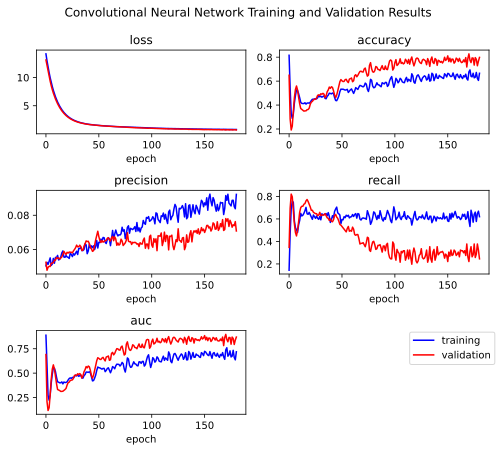

In [34]:
metrics = ["loss","accuracy", "precision", "recall", "auc"]
fig = plt.figure(figsize=(7, 6))

for i in range(len(metrics)): 
    metric = metrics[i]
    ax = fig.add_subplot(3,2,i+1)
    tr_pl = hist_df.plot("epoch", metric, label="training", ax=ax, color="blue")
    val_pl = hist_df.plot("epoch","val_"+metric, label="validation", ax=ax, color="red")
    ax.set_title(metric)
    ax.get_legend().remove()

handles,labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(0.5, 0., 0.5, 0.5))
fig.tight_layout()
fig.suptitle("Convolutional Neural Network Training and Validation Results", y=1.04)
plt.show()

fig.savefig("../../figs/cnn_model_results.png", dpi=300, bbox_inches='tight')

## 3. Compute model evaluation metrics 

In [23]:
# https://www.tensorflow.org/guide/keras/training_with_built_in_methods
loss_train, acc_train, prec_train, recall_train, auc_train = model.evaluate(
    x_train, y_train_onehot, 
    verbose=0, 
    #batch_size=settings["batch_size"]
)

loss_val, acc_val, prec_val, recall_val, auc_val = model.evaluate(
    x_val, y_val_onehot, 
    verbose=0
    #batch_size=settings["batch_size"]
)

# loss_test, acc_test, prec_test, recall_test, auc_test = model.evaluate(
#     x_test, y_test_onehot, 
#     #batch_size=settings["batch_size"]
# )

In [24]:
model_metrics = pd.DataFrame(
    {
        "Loss":[loss_train,loss_val],
        "Accuracy":[acc_train,acc_val],
        "Precision":[prec_train,prec_val],
        "Recall":[recall_train,recall_val],
        "AUC":[auc_train,auc_val]
},
    index=["training","validation"]
)
display(model_metrics)

,Loss,Accuracy,Precision,Recall,AUC
training,0.720679,0.782499,0.115677,0.484076,0.863121
validation,0.700846,0.827502,0.078059,0.221557,0.896566


## 4. Make predictions using trained model

Predictions are the probability that the data falls into each class. 

In [25]:
P_train = model.predict(x_train)
P_val = model.predict(x_val)
P_test = model.predict(x_test)

99/99 [==============================] - 0s 3ms/step


For example, see the probabilities below: 

In [26]:
P_train

array([[0.6659902 , 0.3340098 ],
       [0.67320305, 0.32679695],
       [0.6696861 , 0.3303139 ],
       ...,
       [0.66715306, 0.33284688],
       [0.68135244, 0.3186476 ],
       [0.6689258 , 0.33107418]], dtype=float32)

Thus, we will need to convert the data to our classes of either 0 or 1. If the probability that the data is class 1 is greater than 0.5, we will assign that value to class 1. 

In [27]:
def get_class_predictions_df(predictions): 
    """Assign class predicions. Output as pandas dataframe

    Parameters 
    ----------
    predictions: 2D np.array 
        probability predictions from model 

    Returns
    -------
    pd.DataFrame
    
    """
    predict_df = pd.DataFrame(predictions)
    predict_df = predict_df.rename(columns = {0: 'prob_0', 1: 'prob_1'})
    predict_df['predicted_class'] = np.argmax(predictions, axis=1)
    return predict_df

In [28]:
P_train_df = get_class_predictions_df(P_train)
P_train_df["actual_class"] = y_train
P_train_df["set"] = ["training"]*len(P_train_df)

P_val_df = get_class_predictions_df(P_val)
P_val_df["actual_class"] = y_val
P_val_df["set"] = ["validation"]*len(P_val_df)

P_test_df = get_class_predictions_df(P_test)
P_test_df["actual_class"] = y_test
P_test_df["set"] = ["testing"]*len(P_test_df)

col_subset = ["predicted_class","actual_class","set"]
P_all_df = pd.concat([
    P_train_df[col_subset],
    P_val_df[col_subset],
    P_test_df[col_subset]
])

In [29]:
# Get time indices 
train_idx = list(y_train_df.time.values)
val_idx = list(y_val_df.time.values)
test_idx = list(y_test_df.time.values)

# Add to dataframe 
P_all_df["time"] = pd.to_datetime(train_idx + val_idx + test_idx)

P_all_df.head()

,predicted_class,actual_class,set,time
0,0,0,training,1981-01-01
1,0,0,training,1981-01-02
2,0,0,training,1981-01-03
3,0,0,training,1981-01-04
4,0,0,training,1981-01-05


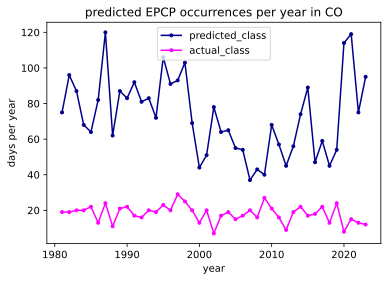

In [43]:
# Compute number EPCP per year 
num_EPCP_by_yr = P_all_df.groupby(P_all_df.time.dt.year)[["predicted_class","actual_class"]].sum()
EPCP_by_yr = pd.DataFrame(num_EPCP_by_yr )

# Make a plot 
fig, ax = plt.subplots(figsize=(6,4))
pl_pred = EPCP_by_yr.plot(y="predicted_class", ax=ax, marker=".", color="darkblue")
pl_actual = EPCP_by_yr.plot(y="actual_class", ax=ax, marker=".", color="magenta")
plt.xlabel("year") 
plt.ylabel("days per year")
plt.legend(loc="upper center")
plt.title("predicted EPCP occurrences per year in CO") 
plt.show()

fig.savefig("../../figs/predicted_EPCP_by_yr.png", dpi=300, bbox_inches='tight')